# **Parte 1. Construcción de una Serie de Tiempo**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Extraemos los datos raw
#Nos saltamos 151 renglones
url='https://raw.githubusercontent.com/Majoramu/Fisica_Computacional1/main/Evaluaci%C3%B3n/co2_spo_DailyData.txt'
my_cols_orig = ['site_code','year','month','day','hour','minute','second','time_decimal','CO2','value_std_dev','nvalue','latitude','longitude','altitude','elevation','intake_height','qcflag']
df_dist= pd.read_csv(url,names=my_cols_orig,encoding='cp1251',sep='\s+',header=None,skiprows=151,engine='python')

#Hacemos una copia de trabajo y preservamos el dataframe original
df_work=df_dist.copy()

#Cambiamos los datos tipo fecha
df_work['Fecha']=pd.to_datetime(dict(day=df_work['day'], month=df_work['month'], year=df_work['year']), dayfirst=True)

df_work.head()

#Reemplazamos los valores -999.99 por NaN 
str_Nan=-999.99
df_work00=df_work.replace(to_replace=str_Nan,value='NaN',regex=True)

#Enfocamos el análisis al periodo 1980-2019
df_work0=df_work00[(df_work00['year']>=1980)& (df_work00['year']<=2019)]
print(df_work0.head())
print(df_work0.tail())

#Construímos un DataFrame con las dos columnas de interés
df_work1=df_work0[['Fecha','CO2']]
df_work1.head()

#Creamos la Fecha como índice
df_work1= df_work1.set_index('Fecha')
df_work1.head()

#Usamos la función ts_test.ffill(axis=0, inplace=True) para rellenar hacia enfrente los valores vacíos al último valor anterior disponible
df_work1.ffill(axis=0,inplace=True)

#Convertimos los datos de CO2 a números flotantes
df_work1['CO2']=pd.to_numeric(df_work1['CO2'],errors='coerce')

ts_test=df_work1.copy()
ts_test.ffill(axis=0,inplace=True)
ts_test.info()
print(ts_test.head())

     site_code  year  month  day  ...  elevation  intake_height  qcflag      Fecha
1826       SPO  1980      1    1  ...     2810.0           13.5     ... 1980-01-01
1827       SPO  1980      1    2  ...     2810.0           13.5     ... 1980-01-02
1828       SPO  1980      1    3  ...     2810.0           13.5     ... 1980-01-03
1829       SPO  1980      1    4  ...     2810.0           13.5     ... 1980-01-04
1830       SPO  1980      1    5  ...     2810.0           13.5     ... 1980-01-05

[5 rows x 18 columns]
      site_code  year  month  day  ...  elevation  intake_height  qcflag      Fecha
16431       SPO  2019     12   27  ...     2810.0          11.28     ... 2019-12-27
16432       SPO  2019     12   28  ...     2810.0          11.28     ... 2019-12-28
16433       SPO  2019     12   29  ...     2810.0          11.28     ... 2019-12-29
16434       SPO  2019     12   30  ...     2810.0          11.28     ... 2019-12-30
16435       SPO  2019     12   31  ...     2810.0          

# **Parte 2. Análisis de la Serie de Tiempo**

In [3]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='pink',label='Original')
    plt.plot(rolmean, color='green', label='Rolling Mean')
    plt.plot(rolstd, color='purple', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

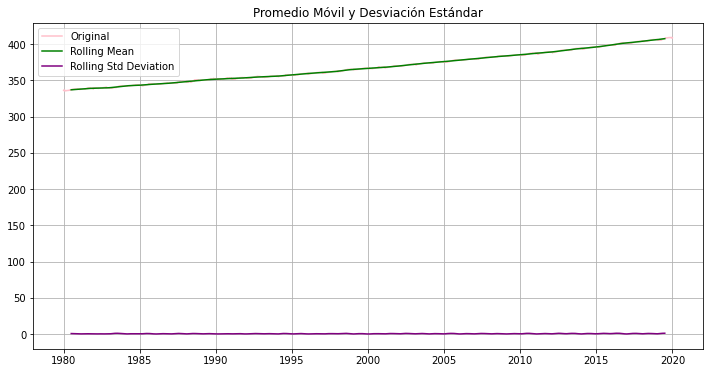

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.973933
p-value                            0.993983
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [4]:
# Realizamos la Prueba de Estacionaridad de CO2
test_stationarity(ts_test['CO2'])

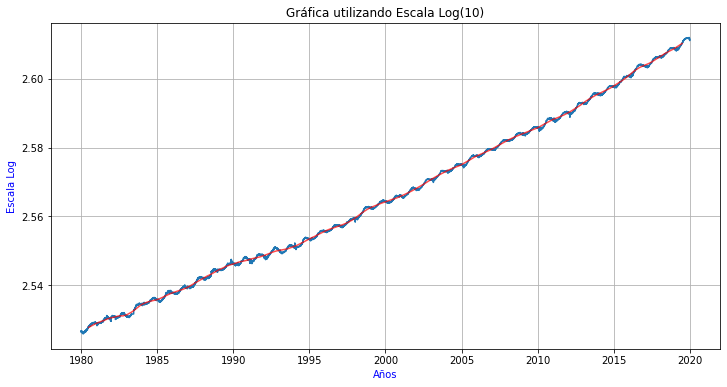

In [5]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
moving_avg = ts_test_log.rolling(365,center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'red',alpha=0.7)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

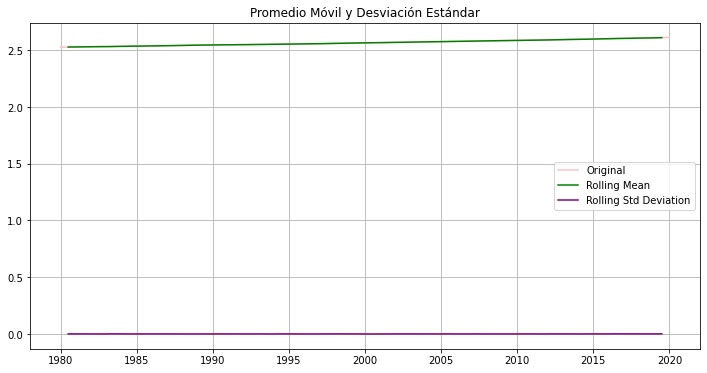

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.538071
p-value                            0.985985
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [6]:
test_stationarity(ts_test_log['CO2'])

La prueba nos dice que no es estacionaria

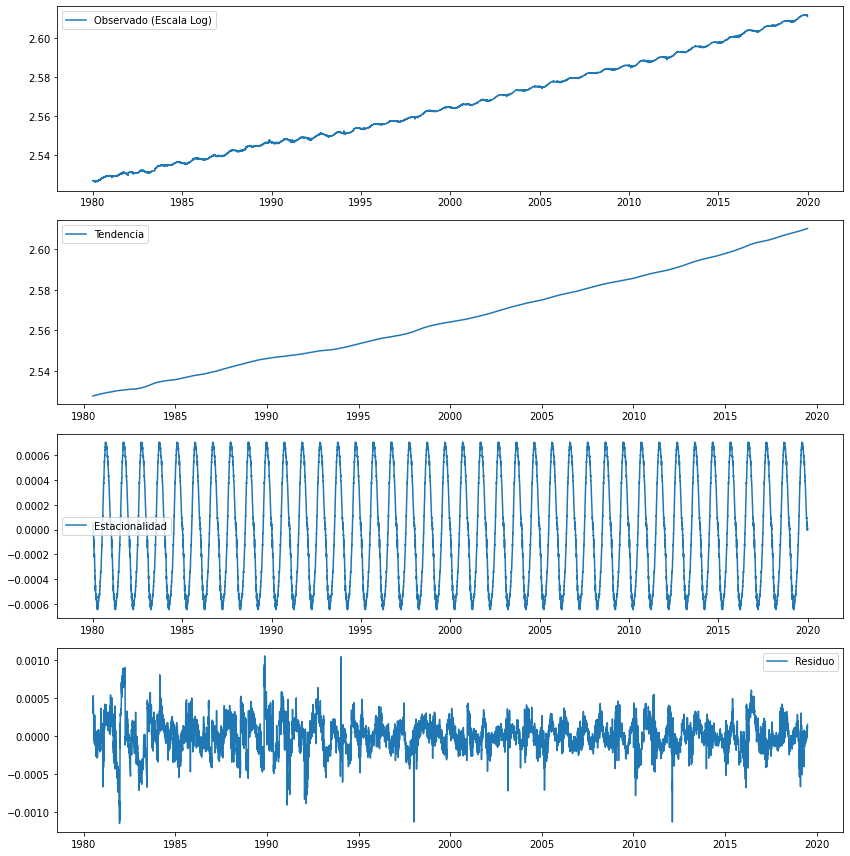

In [7]:
# Método de descomposición usando la biblioteca statsmodels.tsa
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia(trend), estacionalidad(seasonal) y un residuo(residue)
trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

Lo que se puede decir de las gráficas es que la tendencia del CO2 aumenta de manera constante. No se ve una dependencia con las estaciones, pero se ve que existen una variabilidad en distintos periodos, así como la variabilidad del residuo que se ve que va disminuyendo poco a poco. 

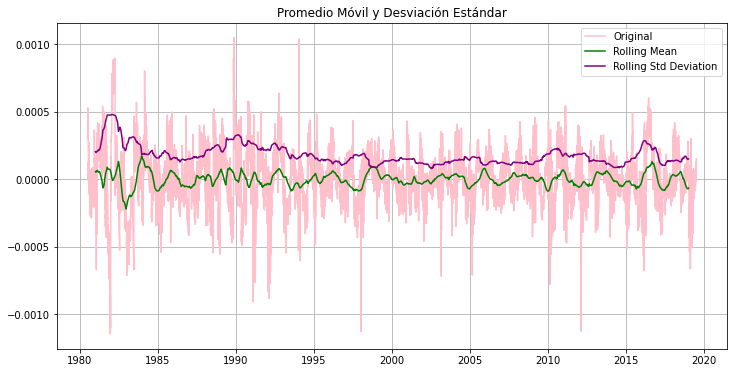

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135572e+01
p-value                        9.746288e-21
#Lags Used                     2.800000e+01
Number of Observations Used    1.421700e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [8]:
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
ts_test_log_decompose .head()
test_stationarity(ts_test_log_decompose['CO2'])

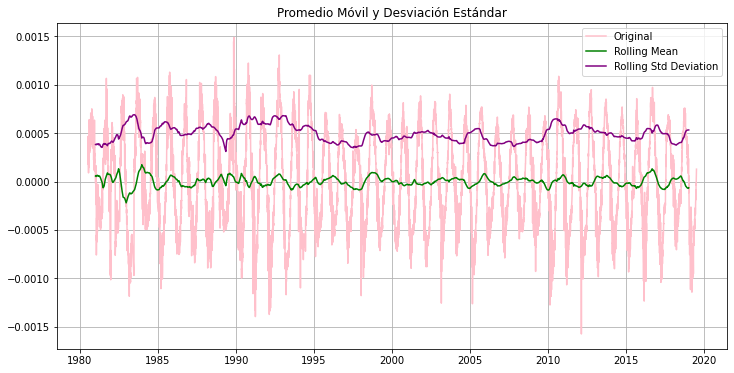

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135538e+01
p-value                        9.763779e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.420300e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [9]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()
#Con valores faltantes
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()
#Sin valores Nan
test_stationarity(ts_test_log_moving_ave_diff['CO2'])

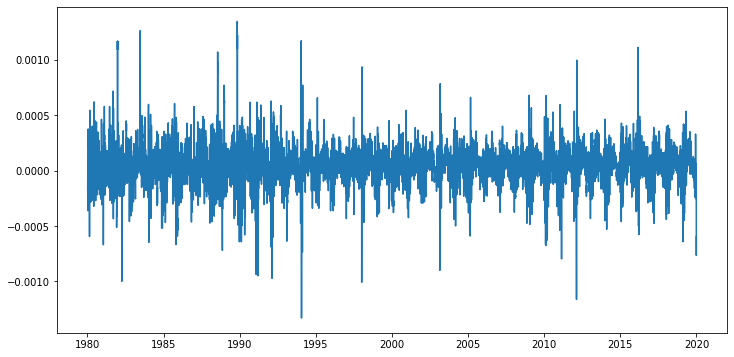

In [10]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff .dropna(inplace=True)
plt.plot(ts_test_log_diff);

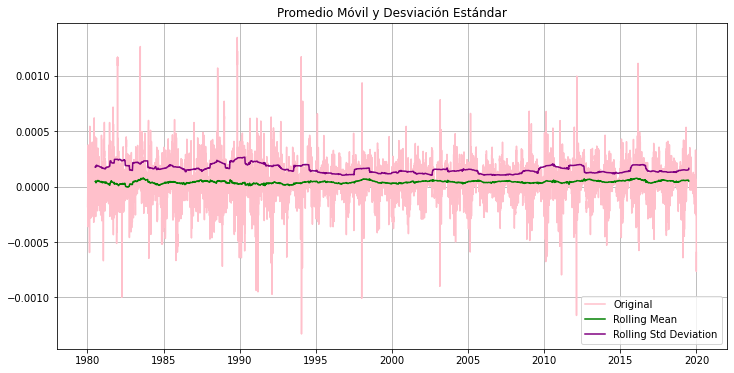

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.171651e+01
p-value                        1.446943e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.456000e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [11]:
test_stationarity(ts_test_log_diff['CO2'])

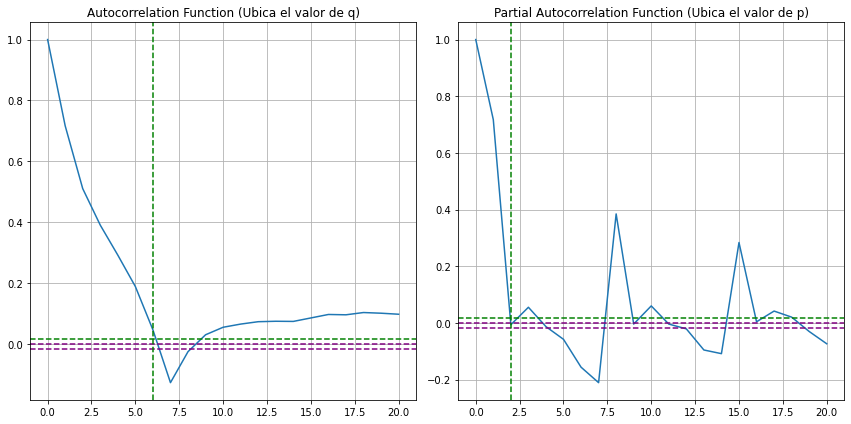

In [12]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='purple')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias

plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='purple')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 6, por lo que haremos q=6.

Con estos dos valores construiremos los modelos ARIMA correspondientes.

## **Modelo AR (Auto-Regresión)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116098.859
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232189.718
Time:                        01:52:46   BIC                        -232159.360
Sample:                    01-02-1980   HQIC                       -232179.632
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.788e-06   5.33e-07     10.851      0.000    4.74e-06    6.83e-06
ar.L1.D.CO2    -0.1522      0.008    -18.682      0.000      -0.168      -0.136
ar.L2.D.CO2    -0.1753      0.008    -21.511    

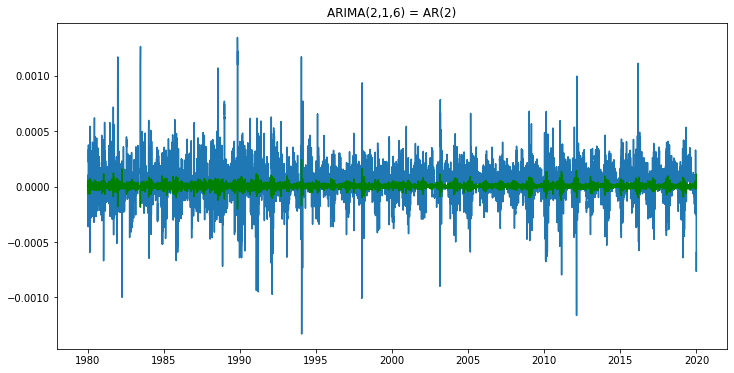

In [13]:
# Modelo AR(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='green')
plt.title('ARIMA(2,1,6) = AR(2)')
print(results_AR.summary())

## **Promedio MA(Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(0, 1, 6)   Log Likelihood              115820.123
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -231624.247
Time:                        01:52:50   BIC                        -231563.532
Sample:                    01-02-1980   HQIC                       -231604.076
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.815e-06   2.44e-07     23.850      0.000    5.34e-06    6.29e-06
ma.L1.D.CO2    -0.1786      0.009    -20.393      0.000      -0.196      -0.161
ma.L2.D.CO2    -0.2081      0.008    -24.684    

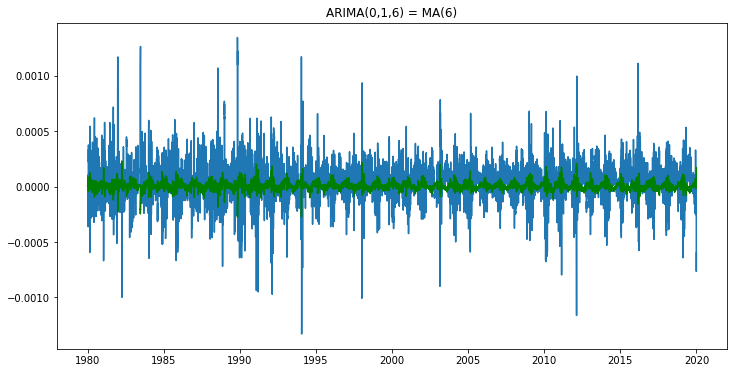

In [14]:
# Modelo MA(q): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='green')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

## **Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116209.927
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232399.855
Time:                        01:53:06   BIC                        -232323.961
Sample:                    01-02-1980   HQIC                       -232374.642
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.795e-06   4.18e-07     13.861      0.000    4.98e-06    6.61e-06
ar.L1.D.CO2     0.3648        nan        nan        nan         nan         nan
ar.L2.D.CO2    -0.6854      0.094     -7.319    

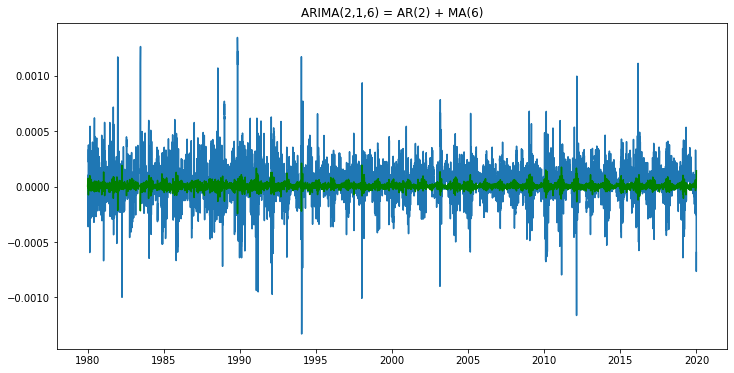

In [15]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='green')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

El Criterio de Información de Akaike (AIC), como indicador del mejor modelo ARIMA.

El criterio AIC se basa en dos principios:

Bondad del ajuste
Simplicidad del modelo o principio de parsimonia.
Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros.

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -232189.718

ARIMA(0,1,6): AIC = -231624.247 

ARIMA(2,1,6): AIC = -232399.855 <- **Es el menor AIC**


Podemos afirmar que **ARIMA(2,1,6)** es el mejor modelo de los 3 que exploramos.

- **Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.**

In [16]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Fecha
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000032
1980-01-06    0.000022
dtype: float64

In [17]:
# Sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log['CO2'], index = ts_test_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print('Ts_test:')
print(ts_test_log.head())
print('Predictions_Arima_log')
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Ts_test:
                 CO2
Fecha               
1980-01-01  2.526727
1980-01-02  2.526701
1980-01-03  2.526611
1980-01-04  2.526585
1980-01-05  2.526598
Predictions_Arima_log
Fecha
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
Fecha
2019-12-27    2.611791
2019-12-28    2.611741
2019-12-29    2.611438
2019-12-30    2.611184
2019-12-31    2.611409
dtype: float64


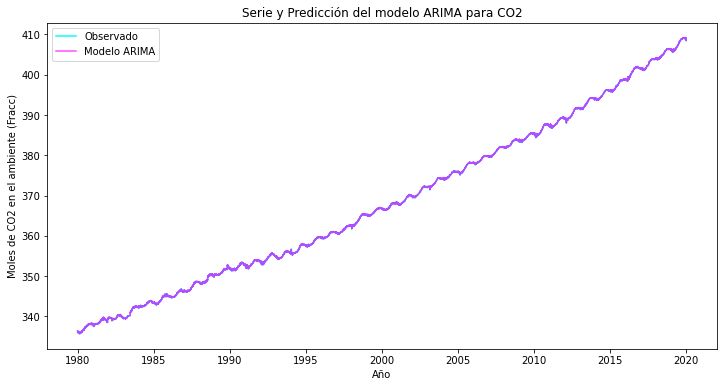

In [24]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado',color='cyan');
plt.plot(predictions_ARIMA, label='Modelo ARIMA',color='magenta',alpha=0.7);
plt.xlabel('Año')
plt.ylabel('Moles de CO2 en el ambiente (Fracc)')

#value:long_name : measured_mole_fraction_of_trace_gas_in_dry_air
# value:units : micromol mol-1
# value:comment : Mole fraction reported in units of micromol mol-1 
#(10-6 mol per mol of dry air); abbreviated as ppm (parts per million).
plt.title('Serie y Predicción del modelo ARIMA para CO2')
plt.legend(loc='best');

In [25]:
#Obtenemos el error RMSE
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test['CO2'])**2))
print('RMSE:', RMSE)

RMSE: 0.018899244271053547


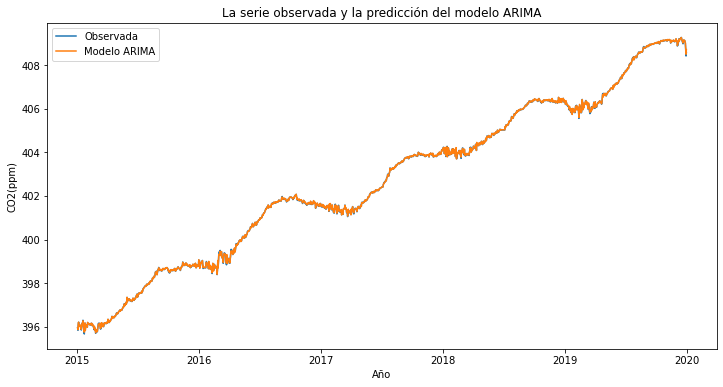

In [26]:
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Año')
plt.ylabel('CO2(ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

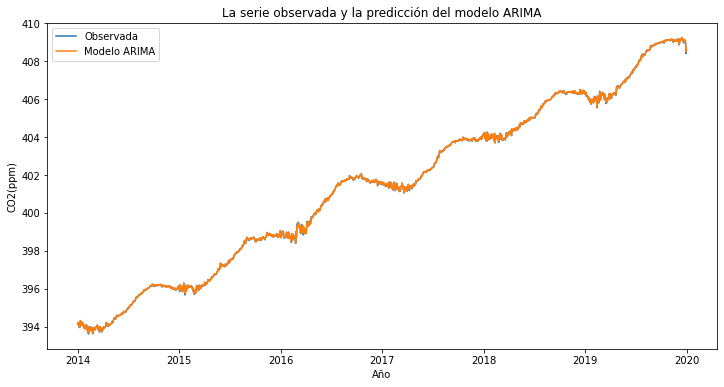

In [27]:
ts_test_last = ts_test.loc['2014-01-01':'2019-12-31']
predictions_ARIMA_last = predictions_ARIMA.loc['2014-01-01':'2019-12-31']
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Año')
plt.ylabel('CO2(ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');